In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [2]:
#date to date format and sorting with it

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['user', 'date'])

In [3]:
#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

In [4]:
data['first_message'].describe()

count    261098.000000
mean          0.028261
std           0.165719
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: first_message, dtype: float64

In [5]:
#unique chaterrs each stream
unique_chatters_per_stream = data.groupby('stream')['user'].nunique()

In [6]:
# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream,
    'unique_chatters': unique_chatters_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

#stream length per firt
stream_stats['stream_length_per_firt'] = stream_stats['first_messages'] / stream_stats['stream_length_hour'] 

#unique chatters per hour
stream_stats['unique_chatters_per_hour'] = stream_stats['unique_chatters'] / stream_stats['stream_length_hour']


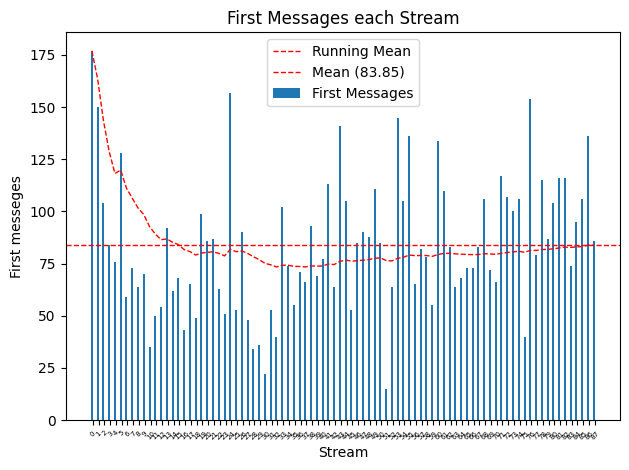

In [7]:
# Plot the chart
fig, ax = plt.subplots()

# Bar width
bar_width = 0.35

# Bar positions
index = range(len(stream_stats))

# Bar plots
bar1 = ax.bar(index, stream_stats['first_messages'], bar_width, label='First Messages')

# Calculate mean of first messages
mean_first_messages = stream_stats['first_messages'].mean()

stream_stats['first_messages_avg'] = stream_stats['first_messages'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['first_messages_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Draw the mean line
ax.axhline(mean_first_messages, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_first_messages:.2f})')

# Labels and title
ax.set_xlabel('Stream', fontsize=10)
ax.set_ylabel('First messeges', fontsize=10)
ax.set_title('First Messages each Stream', fontsize=12)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(stream_stats.index, fontsize=5)  # Adjust x-tick labels font size
ax.legend(fontsize=10)

# Display the plot
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()


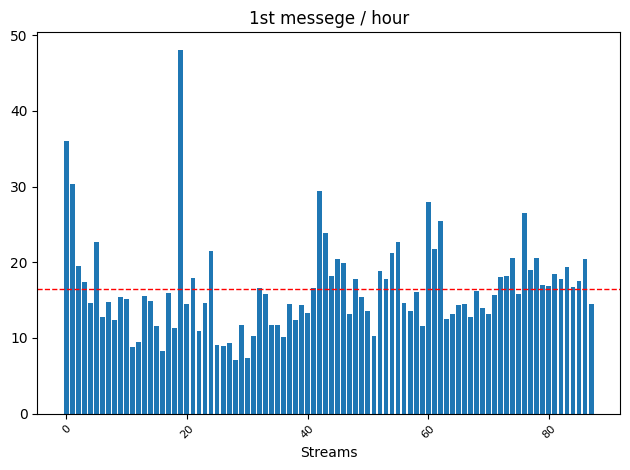

In [8]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['stream_length_per_firt'])

# Calculate mean of first messages
mean_stream_length_per_firt = stream_stats['stream_length_per_firt'].mean()

# Draw the mean line
ax.axhline(mean_stream_length_per_firt, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_stream_length_per_firt:.2f})')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_title('1st messege / hour', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

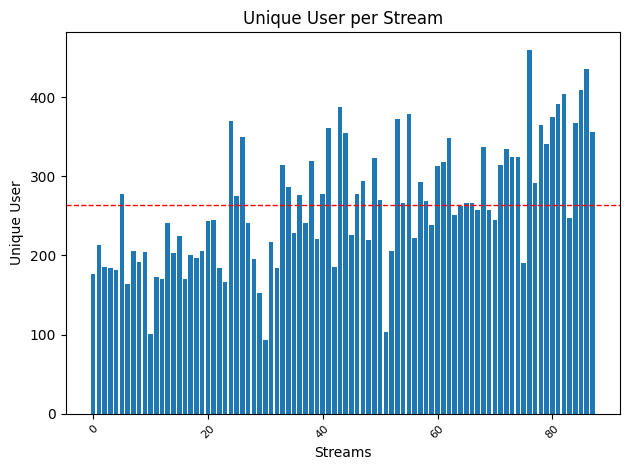

In [9]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['unique_chatters'])

# Calculate mean of first messages
mean_stream_unique = stream_stats['unique_chatters'].mean()

# Draw the mean line
ax.axhline(mean_stream_unique, color='r', linestyle='--', linewidth=1, label=f'Mean ({mean_stream_unique:.2f})')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Unique User', fontsize=10)
ax.set_title('Unique User per Stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

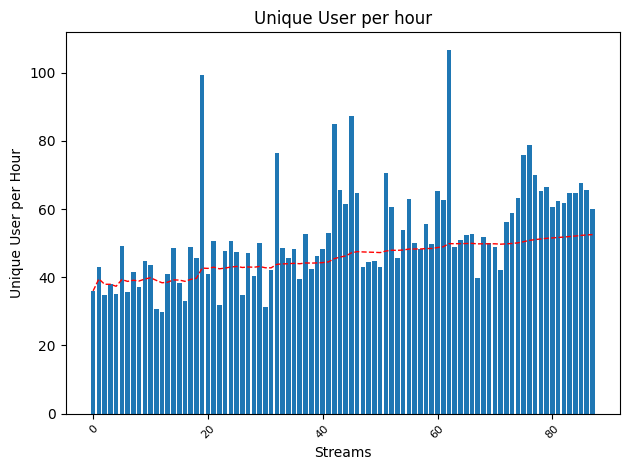

In [10]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['unique_chatters_per_hour'])

# Calculate mean of first messages
stream_stats['unique_chatters_per_hour_avg'] = stream_stats['unique_chatters_per_hour'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['unique_chatters_per_hour_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Unique User per Hour', fontsize=10)
ax.set_title('Unique User per hour', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [11]:
# Group by stream and aggregate users
stream_users = data.groupby('stream')['user'].apply(set).reset_index()
stream_users.columns = ['stream', 'users']

# Initialize columns for returning users and their count
stream_users['returning_users'] = [set()] * len(stream_users)
stream_users['returning_count'] = 0

# Loop through streams to identify returning users
for i in range(1, len(stream_users)):
    current_users = stream_users.at[i, 'users']
    previous_users = stream_users.at[i - 1, 'users']
    
    # Identify returning users
    returning_users = current_users.intersection(previous_users)
    
    # Update dataframe with returning users and their count
    stream_users.at[i, 'returning_users'] = returning_users
    stream_users.at[i, 'returning_count'] = len(returning_users)

In [12]:
stream_stats = pd.merge(stream_stats, stream_users, on='stream', how='right')

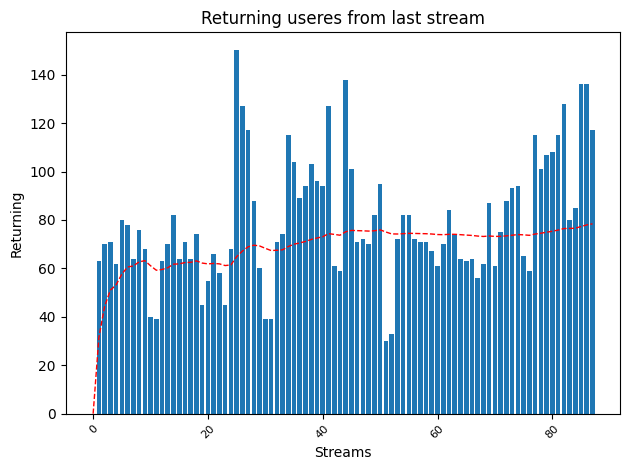

In [13]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for stream_length_per_first
ax.bar(stream_stats.index, stream_stats['returning_count'])

# Calculate mean of first messages
stream_stats['returning_count_avg'] = stream_stats['returning_count'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['returning_count_avg'], color='r', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('Returning', fontsize=10)
ax.set_title('Returning useres from last stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [14]:
# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow'], skiprows=1)

# Display the DataFrame
exelStats.head(2)

,stream,avg,max,follow
0,0,129,145,9
1,1,152,290,24


In [15]:
stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')


In [16]:
#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

In [17]:
#2 or more messeges
stream_stats['two_or_more_message_user_counts'] = stream_stats['unique_chatters'] - stream_stats['one_message_user_count']

In [18]:
#message per chater
stream_stats['message_per_chater'] = stream_stats['total_messages'] / stream_stats['unique_chatters']

In [19]:
#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

In [20]:
#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

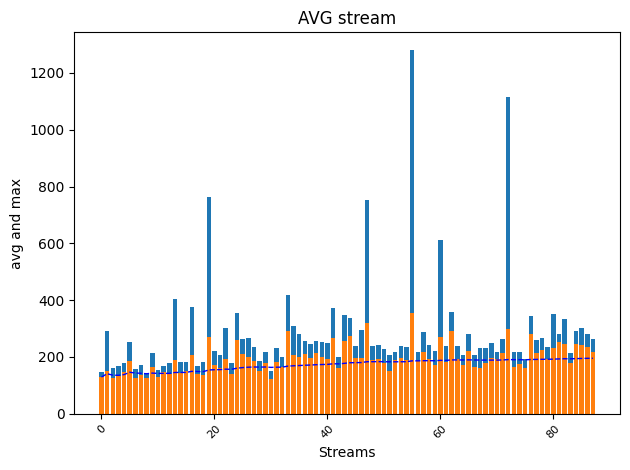

In [21]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for max viever
ax.bar(stream_stats.index, stream_stats['max'])

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'])


# Calculate mean of first messages
stream_stats['epanding_avg'] = stream_stats['avg'].expanding().mean()

# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

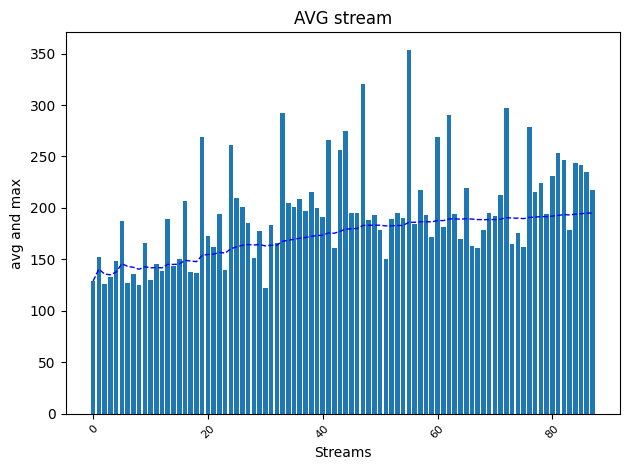

In [22]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['avg'])

# Plot the running mean line
ax.plot(index, stream_stats['epanding_avg'], color='b', linestyle='--', linewidth=1, label='Running Mean')

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('avg and max', fontsize=10)
ax.set_title('AVG stream', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

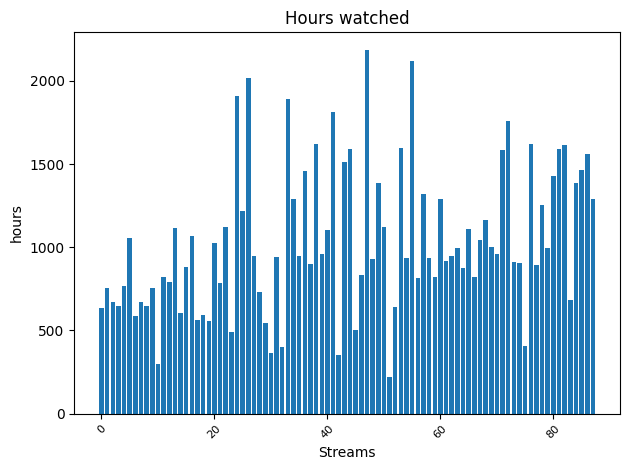

In [23]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['hours_watched'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Hours watched', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [24]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   stream                           88 non-null     int64  
 1   first_messages                   88 non-null     int64  
 2   total_messages                   88 non-null     int64  
 3   unique_chatters                  88 non-null     int64  
 4   stream_length                    88 non-null     float64
 5   stream_length_hour               88 non-null     float64
 6   stream_length_per_firt           88 non-null     float64
 7   unique_chatters_per_hour         88 non-null     float64
 8   first_messages_avg               88 non-null     float64
 9   unique_chatters_per_hour_avg     88 non-null     float64
 10  users                            88 non-null     object 
 11  returning_users                  88 non-null     object 
 12  returning_count         

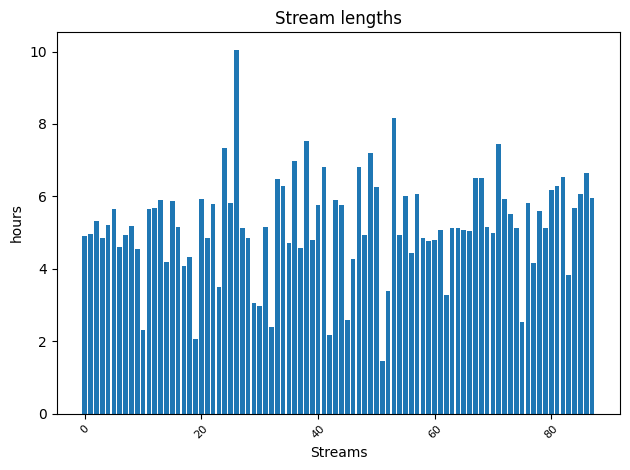

In [25]:
# Plot the chart
fig, ax = plt.subplots()

# Bar plot for abg viever
ax.bar(stream_stats.index, stream_stats['stream_length_hour'])

# Labels and title
ax.set_xlabel('Streams', fontsize=10)
ax.set_ylabel('hours', fontsize=10)
ax.set_title('Stream lengths', fontsize=12)

# Display the plot
plt.xticks(rotation=45, fontsize=8)  # Rotate x labels if necessary
plt.tight_layout()
plt.show()

In [26]:

stream_stats.head(2)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,returning_count_avg,avg,max,follow,one_message_user_count,two_or_more_message_user_counts,message_per_chater,hours_watched,total_word_count,epanding_avg
0,0,177,1985,177,17697.0,4.915833,36.006103,36.006103,177.0,36.006103,...,0.0,129,145,9,55,122,11.214689,634.142500,10568,129.0
1,1,150,3046,213,17831.0,4.953056,30.284336,43.003758,163.5,39.504930,...,31.5,152,290,24,58,155,14.300469,752.864444,14301,140.5


In [27]:
stream_stats.tail(2)

,stream,first_messages,total_messages,unique_chatters,stream_length,stream_length_hour,stream_length_per_firt,unique_chatters_per_hour,first_messages_avg,unique_chatters_per_hour_avg,...,returning_count_avg,avg,max,follow,one_message_user_count,two_or_more_message_user_counts,message_per_chater,hours_watched,total_word_count,epanding_avg
86,86,136,4853,435,23912.0,6.642222,20.475075,65.490130,83.827586,52.410131,...,77.965517,235,280,123,147,288,11.156322,1560.922222,19273,194.862069
87,87,86,3215,356,21392.0,5.942222,14.472700,59.910247,83.852273,52.495359,...,78.409091,217,262,46,121,235,9.030899,1289.462222,13713,195.113636


In [28]:
#stream_stats.to_csv('combined_output.csv', index=False)

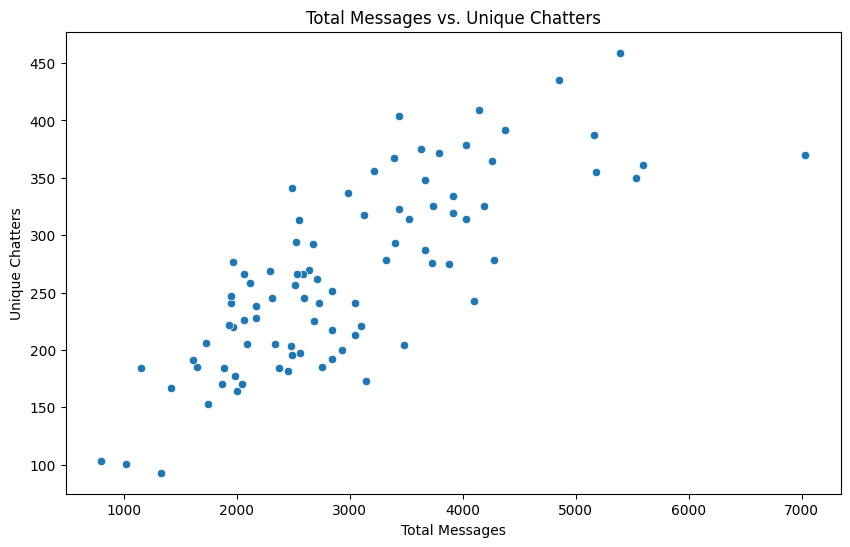

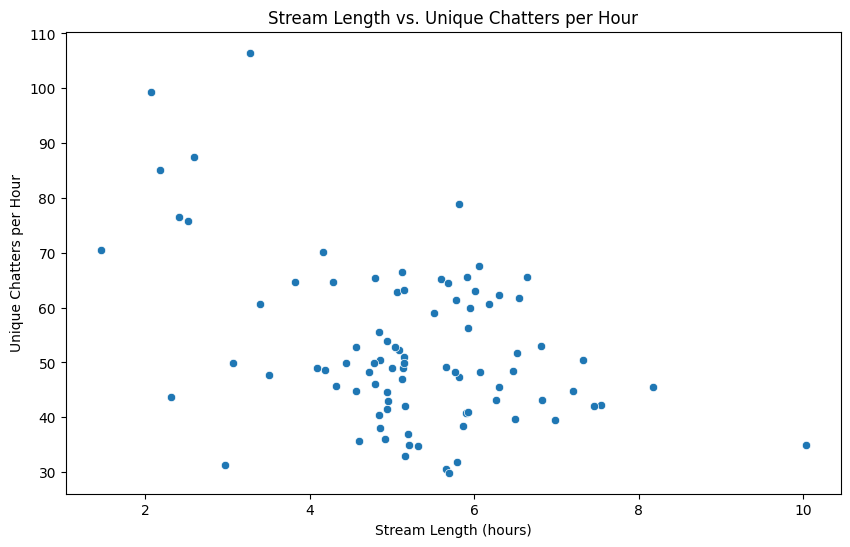

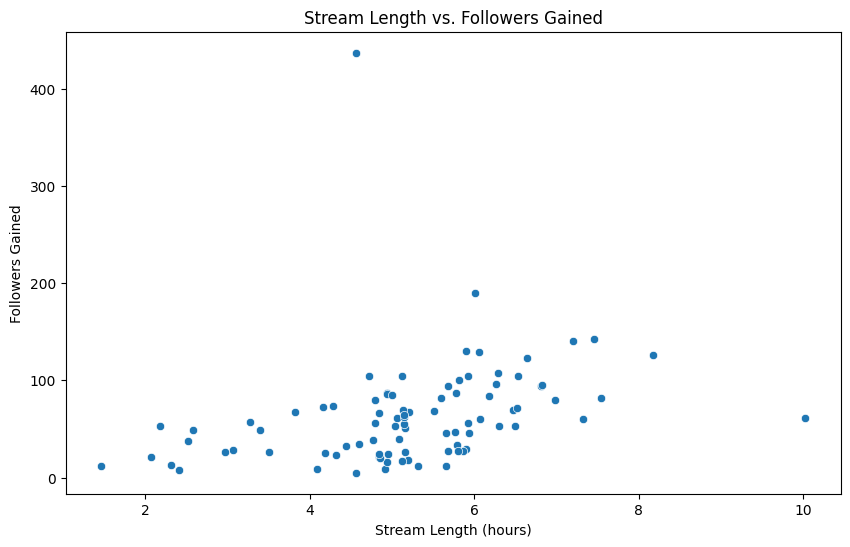

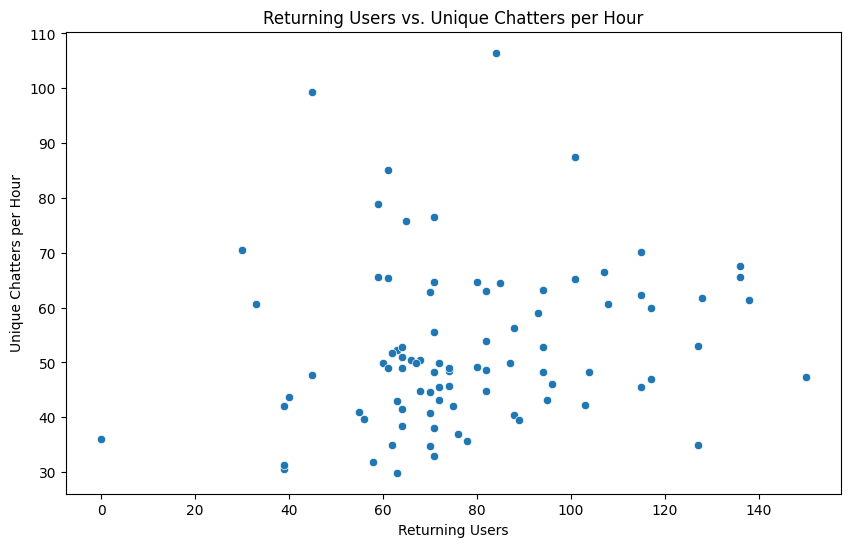

In [29]:

# Scatter plot for Total Messages vs. Unique Chatters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['total_messages'], y=stream_stats['unique_chatters'])
plt.title('Total Messages vs. Unique Chatters')
plt.xlabel('Total Messages')
plt.ylabel('Unique Chatters')
plt.show()

# Scatter plot for Stream Length vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Stream Length vs. Unique Chatters per Hour')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Unique Chatters per Hour')
plt.show()

# Scatter plot for Stream Length vs. Followers Gained
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['stream_length_hour'], y=stream_stats['follow'])
plt.title('Stream Length vs. Followers Gained')
plt.xlabel('Stream Length (hours)')
plt.ylabel('Followers Gained')
plt.show()

# Scatter plot for Returning Users vs. Unique Chatters per Hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x=stream_stats['returning_count'], y=stream_stats['unique_chatters_per_hour'])
plt.title('Returning Users vs. Unique Chatters per Hour')
plt.xlabel('Returning Users')
plt.ylabel('Unique Chatters per Hour')
plt.show()

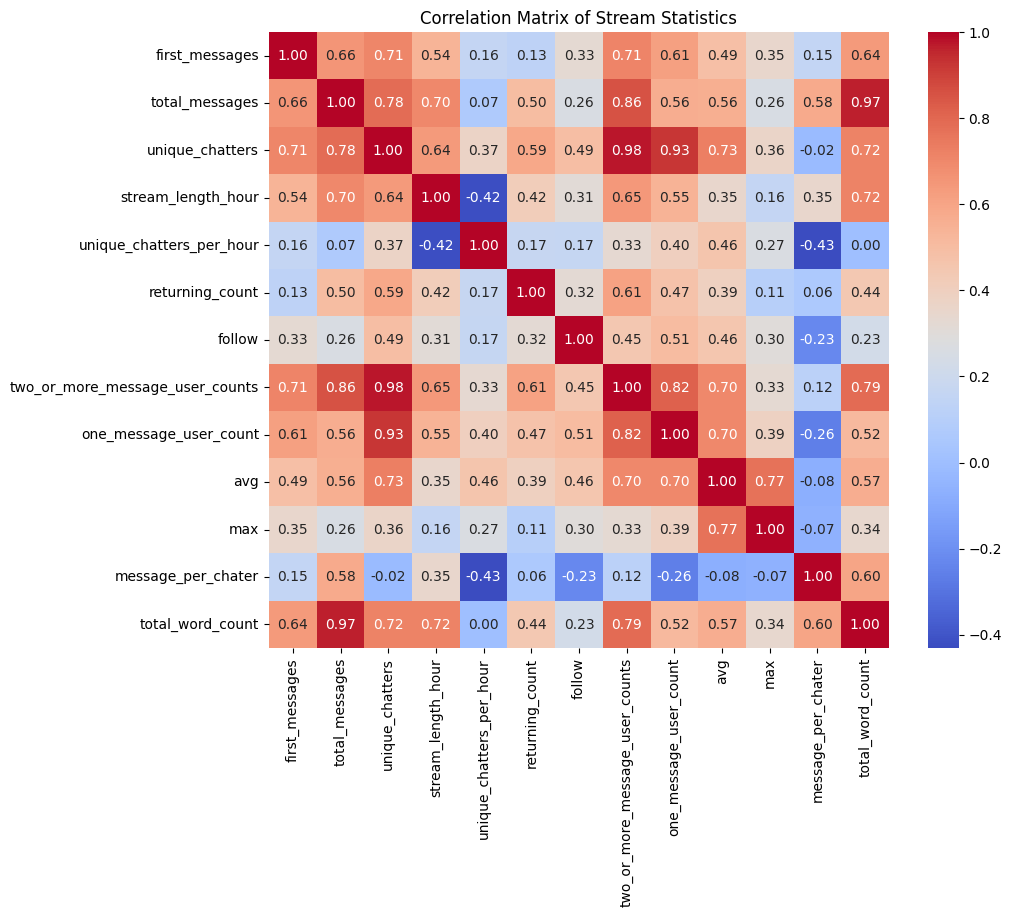

In [30]:
# Correlation matrix for selected columns
correlation_matrix = stream_stats[[ 'first_messages',
                                    'total_messages',
                                    'unique_chatters',
                                    'stream_length_hour',
                                    'unique_chatters_per_hour',
                                    'returning_count',
                                    'follow',
                                    'two_or_more_message_user_counts',
                                    'one_message_user_count',
                                    'avg',
                                    'max',
                                    'message_per_chater',
                                    'total_word_count'
                                    ]].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stream Statistics')
plt.show()